<a href="https://colab.research.google.com/github/o93/bayesian-ab/blob/main/BeyesianAB_PyMC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 使い方

簡易的なベイジアンABテスト検証ツールのPyMC3版です．

1. githubにて，↑のOpen in Colabボタンを押して開きます
1. ABテストの現状の結果を入力します
    - アクセス数・CV数それぞれ1以上でないと判定できません
1. 判定のしきい値を入力します（任意
    - 例えば90%の確率でABの優劣を判定したい場合は，`0.9`と入力します
1. サンプルサイズを入力します（任意
    - サンプリングを多くすると処理に時間を要しますが，判定のブレが少なくなります
1. 各セルの右上に表示されている▶を順番に押していきます
    - 上部メニューのランタイムから「すべてのセルを実行」なら一度にすべて実行できます

提供元リポジトリ: [github](https://github.com/o93/bayesian-ab)

## 準備

In [1]:
!pip install pymc3
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 4.8 MB/s 
     |████████████████████████████████| 1.8 MB 36.5 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=76ab6bed5d1b3a3494c01ad889d51d3270bee2a1e0e14c7f2f6d96bfff33fb58
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 5.0 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=e5b103542de736491e763e7f45860a1943332be110169b8df3268594969b782e
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


## 入力と実行

サンプリング




確率分布の描画
    A -> test 0
    B -> test 1


サマリー


,アクセス数,CV数,CV率,HDI下限値,HDI上限値
A,122,11,0.090164,0.052467,0.137670
B,169,24,0.142012,0.101641,0.191026


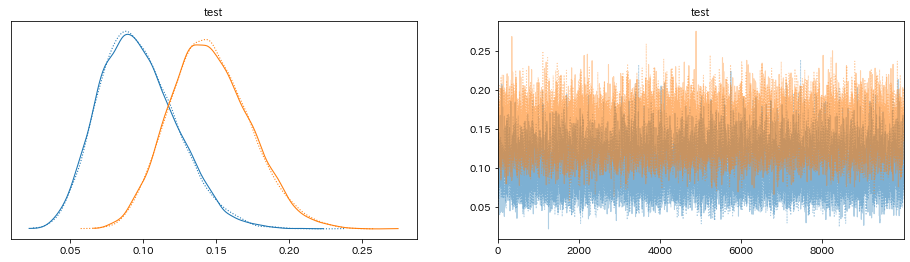

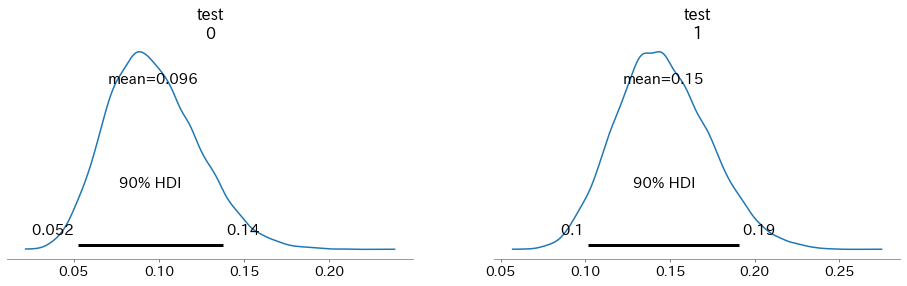

In [5]:
from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pymc3 as pm
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')


#@markdown ABそれぞれに(例:アクセス数,コンバージョン数)を入力
a = (122, 11) #@param {type:"raw"}, {type:"raw"}
b = (169, 24) #@param {type:"raw"}

#@markdown しきい値を入力
threshold = 0.9 #@param {type:"number", min:0.0, max:1.0}

#@markdown サンプルサイズを入力
sample_size = 10000 #@param {type:"integer", min:0, max:1000000}


print('サンプリング')
with pm.Model() as model:
    theta = pm.Uniform('test', lower=0, upper=1, shape=2)
    obs = pm.Binomial('AB', p=theta, n=[a[0], b[0]], observed=[a[1], b[1]])
    trace = pm.sample(sample_size, chains=2)

print()
print()
print('確率分布の描画')
print('    A -> test 0')
print('    B -> test 1')

with pm.Model() as model:
    pm.traceplot(trace, figsize=(16, 4))
    pm.plot_posterior(trace, figsize=(16, 4), hdi_prob=threshold)

df = pd.DataFrame([a, b], columns=['アクセス数', 'CV数'])
df.index = ['A', 'B']
df['CV率'] = df['CV数'] / df['アクセス数']

df[['HDI下限値', 'HDI上限値']] = [pm.hdi(trace['test'][:, 0], hdi_prob=threshold), pm.hdi(trace['test'][:, 1], hdi_prob=threshold)]

print()
print()
print('サマリー')
display(df)

## 検証



AよりBが高い確率:90.22%
AよりBが低い確率:9.78%


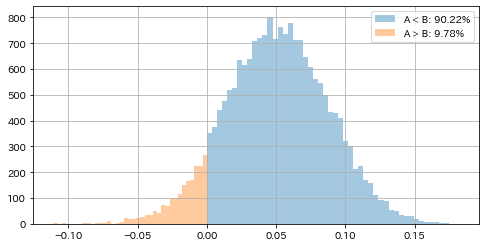



AよりBがどれだけ高いか


サマリー


,B - A,HDI下限値,HDI上限値
0,0.90225,-0.010343,0.113411




しきい値90.0%での判定: Bの勝利！




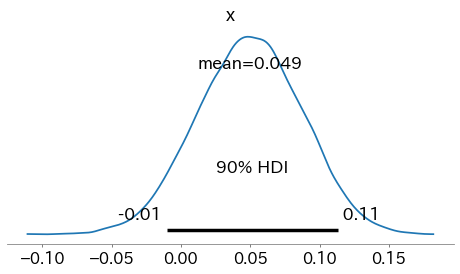

In [6]:
theta_ba = trace['test'][:, 1] - trace['test'][:, 0]
ab_mean = (theta_ba > 0).mean()
ba_mean = (theta_ba < 0).mean()

print()
print()
print(f'AよりBが高い確率:{ab_mean * 100:.2f}%')
print(f'AよりBが低い確率:{ba_mean * 100:.2f}%')

plt.figure(figsize=(8, 4))
sns.distplot(theta_ba[theta_ba > 0], kde=False, label=f'A < B: {ab_mean * 100:.2f}%')
sns.distplot(theta_ba[theta_ba < 0], kde=False, label=f'A > B: {ba_mean * 100:.2f}%')
plt.legend()
plt.grid(True)
plt.show()

print()
print()
print(f'AよりBがどれだけ高いか')

print()
print()
print('サマリー')
df_ab = pd.DataFrame([ab_mean], columns=['B - A'])
df_ab[['HDI下限値', 'HDI上限値']] = pm.hdi(theta_ba, hdi_prob=threshold)
display(df_ab)

print()
print()
print('================================')
if 1 - threshold < ab_mean < threshold:
    print('しきい値{:.1%}での判定: 優位差無し'.format(threshold))
elif ab_mean >= threshold:
    print('しきい値{:.1%}での判定: Bの勝利！'.format(threshold))
else:
    print('しきい値{:.1%}での判定: Aの勝利！'.format(threshold))
print('================================')

print()
print()
pm.plot_posterior(theta_ba, figsize=(8, 4), hdi_prob=threshold)

## 注意点
このHDIは「AよりBが何%高いか」という値が90%の確率でこの範囲に収まる，としたものであり，「AよりBが高い確率」とは異なるものです．具体的には，HDIは確率分布の右側の確率を含みませんが，AよりBが高い確率は，右側の確率を含んでいます．